# 2025-09-12 Formulation

* Goal sharing

* Exploration

* Multiple roots

* Conditioning of the rootfinding problem

* Forward and backward stability

In [1]:
using Plots
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's the Newton's method with history we've been using
function newton_hist(f, fp, x0; tol=1e-12)
    x = x0
    hist = []
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        push!(hist, [x fx fpx])
        if abs(fx) < tol
            return vcat(hist...)
        end
        x = x - fx / fpx
    end
end

newton_hist (generic function with 1 method)

## Exploration

* Find a function $f \left( x \right)$ that models something you’re interested in.
You could consider nonlinear physical models (aerodynamic drag, nonlinear elasticity), behavioral models, probability distributions, or anything else that that catches your interest.
Implement the function in Julia or another language.

* Consider how you might know the output of such functions, but not an input.
Think from the position of different stakeholders: is the equation used differently by an experimentalist collecting data versus by someone making predictions through simulation?
How about a company or government reasoning about people versus the people their decisions may impact?

* Formulate the map from known to desired data as a rootfinding problem and try one or more methods (Newton, bisection, etc., or use a rootfinding library).

* Plot the inverse function (output versus input) from the standpoint of one or more stakeholder.
Are there interesting inflection points?
Are the methods reliable?

* If there are a hierarchy of models for the application you’re interested in, consider using a simpler model to provide an initial guess to a more complicated model.

## Roots with multiplicity

There are multiple ways to represent (monic) polynomials

$$ f \left( x \right) = \left( x - a_1 \right) \left( x - a_2 \right) $$
$$ g \left( x \right) = x^2 - \left( a_1 + a_2 \right) x + a_1 a_2 $$

In [2]:
# Here is the f(x) style above
function poly_eval_prod(x, a) 
    product = 1
    for c in a
        product *= (x - c)
    end
    product
end
# Note, compactly poly_eval_prod(x, a) = prod(x .- a)

# And here is the g(x) style
function poly_eval_sum(x, b)
    sum = 1
    for c in b
        # This is known as Horner's rule
        sum = x * sum + c
    end
    sum
end

# Lets make a couple of functions and compare the effect of perturbations ot each
eps = 1e-10
a = [1e5, 1e5*(1+eps)] # tiny perturbation to root
b = [-(a[1] + a[2])*(1+eps), # tiny perturbation to monomial coefficent
    a[1]*a[2]]
f(x) = poly_eval_prod(x, a)
g(x) = poly_eval_sum(x, b)

g (generic function with 1 method)

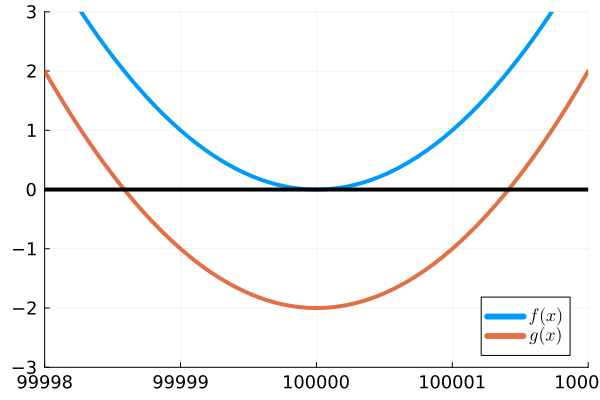

In [3]:
plot([f, g], xlim=(a[1]-2, a[2]+2), ylim=(-3, 3), label=["\$f(x)\$" "\$g(x)\$"])
plot!(zero, color=:black, label=:none)

* Perturbing the coefficient in the 10th digit made the difference between one root or two

* The distance between the roots was large when $b_1$ was perturbed

## How did this happen?

Take a polynomial with two roots at $x = a$ and perturb the middle coefficent.

$$ x^2 + b_1 x + b_2 = 0 $$
$$ x^2 - 2a \left( 1 + \epsilon \right) x + a^2 = 0 $$

Using the quadratic formula, we know that the roots are at

$$ \begin{align} x_* = \frac{b_1}{2} \pm \sqrt{\frac{b_1^2}{4} - b_2} &= a \left(1 + \epsilon \right) \pm \sqrt{a^2 \left( 1 + \epsilon \right)^2 - a^2}\\
&= a \left( 1 + \epsilon \right) \pm a \sqrt{2 \epsilon + \epsilon^2}\\
&\approx a \left( 1 + \epsilon \pm \sqrt{2 \epsilon} \right)
\end{align}
$$

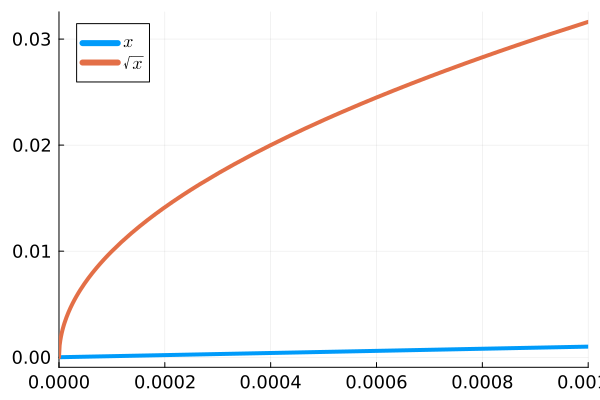

In [4]:
plot([x -> x, sqrt], xlims=(0, .001), label=["\$x\$" "\$\\sqrt{x}\$"])

Note that the condition number is well behaved.

$$ \kappa \left( \sqrt{\epsilon} \right) = \frac{1}{2 \sqrt{\epsilon}} \frac{\epsilon}{\sqrt{\epsilon}} = \frac{1}{2} $$

## Which root does Newton find?

In [5]:
hist = newton_hist(g, x -> 2*x + b[1], 1.1e5; tol=1e-14)

17×3 Matrix{Float64}:
 110000.0            1.0e8       20000.0
 105000.0            2.5e7       10000.0
 102500.0            6.25e6       5000.0
 101250.0            1.5625e6     2500.0
 100625.0            3.90624e5    1250.0
      1.00313e5  97655.6           625.004
      1.00156e5  24413.4           312.509
      1.00078e5   6102.85          156.267
      1.00039e5   1525.21           78.1591
      1.0002e5     380.804          39.1307
      1.0001e5      94.7036         19.6676
 100005.0           23.1862         10.0372
      1.00003e5      5.33626         5.41711
      1.00002e5      0.970375        3.44696
      1.00001e5      0.0792503       2.88392
      1.00001e5      0.00075531      2.82896
      1.00001e5      0.0             2.82843

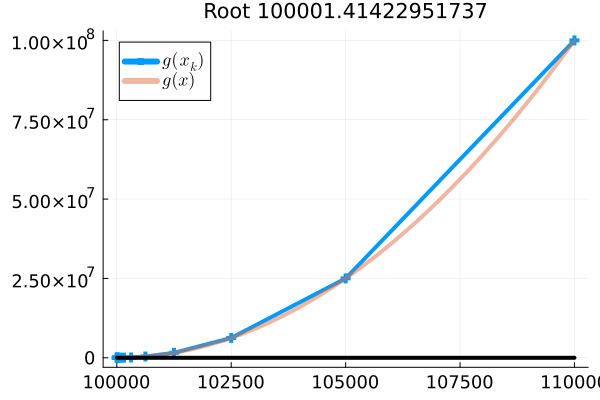

In [6]:
# Let's plot the newton iterations
plot(hist[:,1], hist[:,2], seriestype=:path, marker=:auto, label="\$g(x_k)\$")
plot!(g, title="Root $(hist[end,1])", alpha=.5, label="\$g(x)\$")
plot!(zero, color=:black, label=:none)

* Convergence is slower than we've seen before

* The solution is not nearly as accurate as machine precision

## Using [Polynomials](https://juliamath.github.io/Polynomials.jl/stable/)

Julia has a package for evaluating and manipulating polynomials.
Lets, use it instead of our own hand-rolled approach.

<br>

Note that the coefficients are given in the order $b_0 + b_1 x + b_2 x^2 + \cdots$.

In [7]:
using Polynomials

# Here's how we'd call the equivelent of our two functions above
println("Defining roots (x - a_0)(x - a_1)...")
@show fpoly = fromroots([1, 2] .+ 1e5)
@show derivative(fpoly);

println()
println("Defining coefficients b_0, b_1, ...")
@show gpoly = Polynomial([2, -3, 1])
@show derivative(gpoly);

Defining roots (x - a_0)(x - a_1)...
fpoly = fromroots([1, 2] .+ 100000.0) = Polynomial(1.0000300002e10 - 200003.0*x + 1.0*x^2)
derivative(fpoly) = Polynomial(-200003.0 + 2.0*x)

Defining coefficients b_0, b_1, ...
gpoly = Polynomial([2, -3, 1]) = Polynomial(2 - 3*x + x^2)
derivative(gpoly) = Polynomial(-3 + 2*x)


In [8]:
# And we can feed this directly into our Newton function
newton_hist(fpoly, derivative(fpoly), 3e5)

24×3 Matrix{Float64}:
 300000.0            3.99994e10   399997.0
      2.00001e5      9.99985e9         1.99999e5
      1.50001e5      2.49996e9     99999.3
      1.25001e5      6.24991e8     49999.6
      1.12501e5      1.56248e8     24999.8
      1.06251e5      3.90619e7     12499.9
      1.03126e5      9.76548e6      6249.95
 101564.0            2.44137e6      3124.98
      1.00783e5      6.10342e5      1562.49
      1.00392e5      1.52586e5       781.245
      1.00197e5  38146.3             390.623
      1.00099e5   9536.52            195.313
      1.0005e5    2384.07             97.6589
      1.00026e5    595.954            48.8346
      1.00014e5    148.926            24.4275
      1.00008e5     37.1691           12.2342
      1.00005e5      9.2302            6.15799
      1.00003e5      2.2467            3.16019
      1.00002e5      0.505433          1.73831
      1.00002e5      0.0845417         1.15679
 100002.0            0.00534111        1.01063
 100002.0            2.79307

## Finding *all* roots of polynomials

In [9]:
# There's a convenient function to call!
roots(Polynomial([1e10, -2e5*(1 + 1e-10), 1]))

2-element Vector{Float64}:
  99998.58579643762
 100001.41422356237

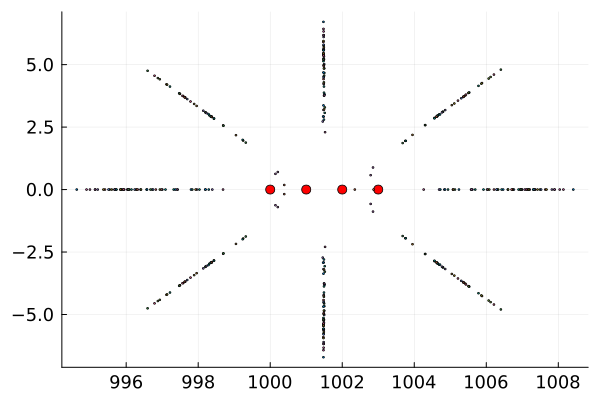

In [10]:
# How does perturbing the coefficients change the roots?
p = fromroots([0., 1., 2, 3] .+ 1000)
xs = roots(p)
scatter(real(xs), imag(xs), color=:red)

# Lets add little random perturbations and find the roots
for i in 1:100
    r = randn(length(p)) # normally distributed mean 0, stddev 1
    q = copy(p)
    q[:] .*= 1 .+ 1e-10 * r
    xs = roots(q)
    scatter!(real(xs), imag(xs), markersize=1)
end
plot!(legend=:none)

## [Fundamental Theorem of Algebra](https://en.wikipedia.org/wiki/Fundamental_theorem_of_algebra)

Every non-zero, single-variable, degree $n$ polynomial with complex coefficients has, counted with multiplicity, exactly $n$ complex roots.

## Exploring - Wilkinson's polynomial

Let's add more terms

$$ w \left( x \right) = \prod_{k = 1}^{20} \left( x - k \right) = \left( x - 1 \right) \left( x - 2 \right) \cdots \left( x - 20 \right) = \sum_{k = 0}^{20} b_k x^k $$

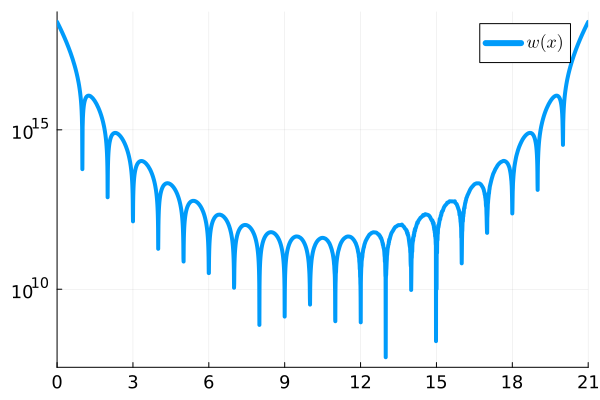

In [11]:
# Let's build this in Julia
n = 20
a = collect(1.:n)
w = fromroots(a)
w[10] *= 1 + 0 * 1e-13 # We can perturb coefficients

# And plot it
plot(x -> abs(w(x)), xlims=(0, n+1), yscale=:log10, label="\$w(x)\$")

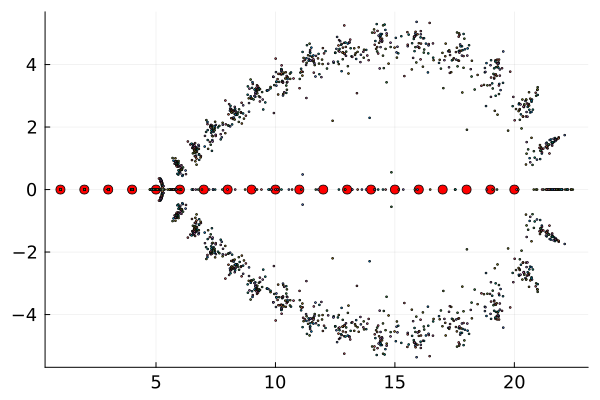

In [12]:
# Trying the plot above again
w = fromroots(a)
scatter(a, zero(a), color=:red)

# Lets add little random perturbations and find the roots
for i in 1:100
    r = randn(length(w))
    q = copy(w)
    q[:] .*= 1 .+ 1e-10 * r
    xs = roots(q)
    scatter!(real(xs), imag(xs), markersize=1)
end
plot!(legend=:none)

### Figure from Trefethen and Bau (1999)

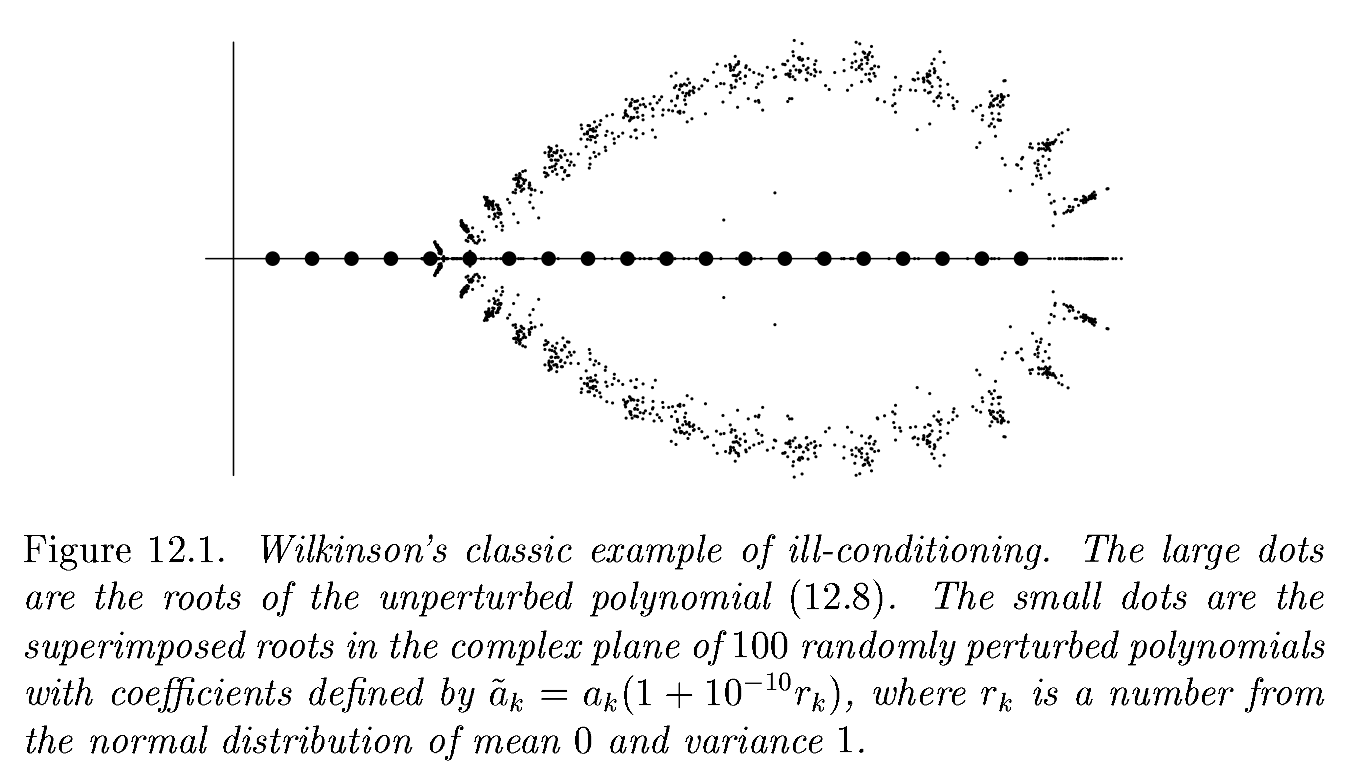

## So which is better for modeling inputs to a rootfinder?

A) coefficients $a_k$ in

$$ p \left( x \right) = \prod_k \left( x - a_k \right) $$

B) coefficients $b_k$ in

$$ p \left( x \right) = \sum_k b_k x^k $$

## Back to forward/backward error and stability

See [FNC](https://tobydriscoll.net/fnc-julia/intro/stability.html#backward-error)

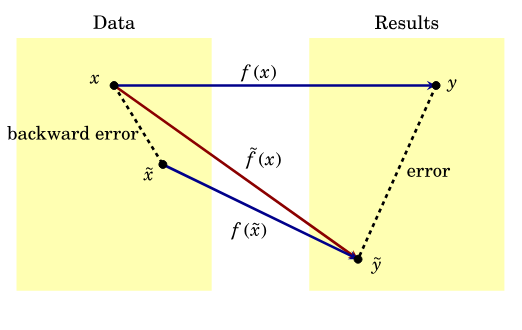

### Stability

**"nearly the right answer to nearly the right question"**

$$ \frac{\left\lvert \tilde{f} \left( x \right) - f \left( \tilde{x} \right) \right\rvert}{\left\lvert f \left( \tilde{x} \right) \right\rvert} \in \mathcal{O} \left( \epsilon_\text{machine} \right) $$

for some $\tilde{x}$ that is close to $x$.

### Backward stability

**"exactly the right answer to nearly the right question"**

$$ \tilde{f} \left( x \right) = f \left( \tilde{x} \right) $$

for some $\tilde{x}$ that is close to $x$.

* Every backward stable algorithm is stable

* Not every stable algorithm is backward stable

### Example - mapping angle to the unit circle

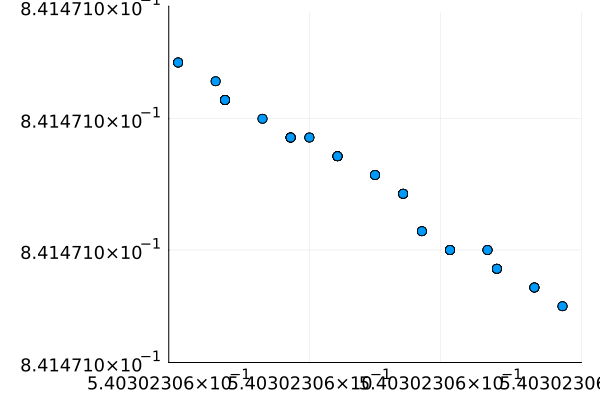

GKS: Possible loss of precision in routine SET_WINDOW


In [13]:
# The points on the unit circle *should* make a smooth curve
theta = 1 .+ LinRange(0, 3e-15, 100)
scatter(cos.(theta), sin.(theta), legend=:none, aspect_ratio=:equal)

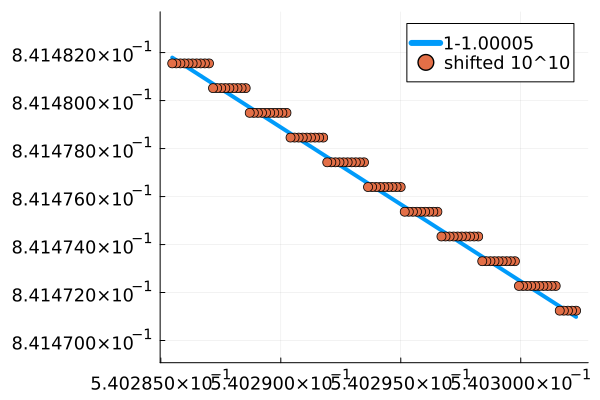

In [14]:
# Lets shift the range of the inputs for sin
theta = LinRange(1., 1+2e-5, 100)
mysin(t) = cos(t - (1e10+1)*pi/2)

plot(cos.(theta), sin.(theta), aspect_ratio=:equal, label="1-1.00005")
scatter!(cos.(theta), mysin.(theta), label="shifted 10^10")

Is this

a) stability

b) backward stability

c) neither

* The numbers $\left( \tilde{\cos} \left( \theta \right), \tilde{\sin} \left( \theta \right) \right) = \left( fl \left( \cos \left( \theta \right) \right), fl \left( \sin \left( \theta \right) \right) \right)$ do not lie exactly on the unit circles

* There does not exist a $\tilde{\theta}$ such that $\left( \tilde{\cos} \left( \theta \right), \tilde{\sin} \left( \theta \right) \right) = \left( \cos \left( \tilde{\theta} \right), \sin \left( \tilde{\theta} \right) \right)$

## Theorem - accuracy of backward stable algorithms

A backward stable algorithm for computing $f \left( x \right)$ has relative accuracy

$$ \frac{\left\lvert \tilde{f} \left( x \right) - f \left( \tilde{x} \right) \right\rvert}{\left\lvert f \left( \tilde{x} \right) \right\rvert} \lesssim \kappa \left( f \right) \epsilon_\text{machine} $$

Backward stability is generally the best we can hope for.

<br>

In practice, it is rarely possible for a function to be backward stable when the output space is higher dimensional than the input space.